In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate as interp
import sys,json,os
sys.path.append('../..')
import matplotlib.pyplot as plt
import Project.profiles as pp
import Project.new_profiles as pnp
import Project.plot_assist as pa
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

In [2]:
dmo = json.load(open('../../sim_RC_12/Output/resdicts/dmo_sim_dict.json','r'))
for gal in dmo:
    dmo[gal]['core_fit'] = dmo[gal]['sidm_fit']
    dmo[gal]['cusp_fit'] = dmo[gal]['nfw_fit']
bry = json.load(open('../../sim_RC_12/Output/resdicts/Bry_2sig_dict.json','r'))
bry_1 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_1sig_dict.json','r'))
bry_p5 = json.load(open('../../sim_RC_12/Output/resdicts/Bry_p5sig_dict.json','r'))
# sparcd = json.load(open('../../obs_RC_v4/Output/result_dicts/sparc_fit_dict_comb.json','r'))
sparcd = json.load(open('../Output/sparc_new_dict.json','r'))

In [3]:
LM = np.zeros([15,15])
RN = np.zeros([15,15])
for lm_i in range(15):
    for rn_i in range(15):
        LM[lm_i,rn_i] = lm_i
        RN[lm_i,rn_i] = 14-rn_i
masses = np.array([9.0,9.3,9.6,9.9,10.2,10.5,10.8,11.1,11.4,11.7,12.0,12.3,12.6,12.9,13.2,13.5])
radius = np.array([0.2,0.4,0.6,0.8,1.0,1.4,1.8,2.2,2.6,3.0,3.4,3.8,4.2,4.6,5.0,5.4])
mass = 0.5*(masses[:-1]+masses[1:])
rad = 0.5*(radius[:-1]+radius[1:])
new_radius = [radius[-i-1] for i in range(len(radius))]
data = [[(1.,1.,1.) for i in range(16)] for i in range(16)]

In [4]:
lsig_edges = np.array([-2,-1,-0.5,0,0.5,1,1.5,2.,2.25,2.5,2.75,3.,3.5,4.,4.5,5])
lsigs = 0.5*(lsig_edges[:-1]+lsig_edges[1:])
LS = [[lsigs[i] for j in range(15)] for i in range(15)]
LS = np.array(LS)

In [5]:
LM_xi = sp.interpolate.interp1d(mass,np.arange(0,15,1),fill_value = (0,14),bounds_error = False)
RN_yi = sp.interpolate.interp1d(rad,np.arange(14,-1,-1),fill_value = (14,0),bounds_error = False)
LS_xi = sp.interpolate.interp1d(lsigs,np.arange(0,15,1),fill_value = (0,14),bounds_error = False)
LS_yi = sp.interpolate.interp1d(lsigs,np.arange(14,-1,-1),fill_value = (14,0),bounds_error = False)

In [7]:
def get_axes(wspace = 0.2,xkey = ['lm','lm'], ykey = ['rn','rn'], title = True):
    fig,axs = plt.subplots(1,2, figsize = (10,5),gridspec_kw = {'wspace':wspace})
    for i in range(2):
        ax = axs[i]
        ax.imshow(data, alpha = 0.)
        ax.set_xticks(np.arange(-0.5,15.5,1))
        if xkey[i] == 'ls':
            ax.set_xticklabels(lsig_edges,rotation = 45)
        else:
            ax.set_xticklabels(masses,rotation = 45)
        ax.set_yticks(np.arange(-0.5,15.5,1))
        if ykey[i] == 'ls':
            ax.set_yticklabels([lsig_edges[-i - 1] for i in range(len(lsig_edges))])
        else:
            ax.set_yticklabels(new_radius)
        ax.tick_params(axis = 'both',direction = 'in',right = True,top = True, width = 1,length = 4)
        ax.grid(ls = '-',color = 'grey',alpha = 0.2)
        if xkey[i] == 'ls':
            ax.set_xlabel('log($\Sigma_0\,/\,\mathrm{M_{\odot}\,pc^{-2}}$)',size = 13,labelpad = 0)
        else:
            ax.set_xlabel('log($\mathrm{M_{200}/M_{\odot}}$)',size = 13,labelpad = 0)
        if ykey[i] == 'ls':
            ax.set_ylabel('log($\Sigma_0\,/\,\mathrm{M_{\odot}\,pc^{-2}}$)',size = 13,labelpad = 0)
        else:
            ax.set_ylabel('$r_{\:\mathrm{last}}\:/\:r_s$',size = 15,labelpad = 0)
        ax.set_ylim(14.5,-0.5)
        ax.set_xlim(-0.5,14.5)
        if title:
            axs[0].set_title('Input: CUSP', color = pa.green)
            axs[1].set_title('Input: CORE', color = pa.purple)
    return fig,axs[0],axs[1]
Clr = lambda clr,l,r = 0.2: [clr[r*(+1)] for i in range(l)]

In [8]:
def Zsmooth(oriX,oriY,oriZ,dN):
    X,Y,Z = oriX.copy(),oriY.copy(),oriZ.copy()
    X2,Y2,Z2 = X[::dN,::dN],Y[::dN,::dN],Z[::dN,::dN]
    Z_smooth =  interp.griddata(np.array([X2.ravel(),Y2.ravel()]).T,Z2.ravel(),(X,Y),method='cubic')
    return Z_smooth
def Delsmall(cn,diametercutoff = 4):
    for level in cn.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            verts = path.vertices
            diameter = np.max(verts.max(axis = 0) - verts.min(axis = 0))

            if diameter < diametercutoff:
                del(level.get_paths()[kp])
    return cn

In [9]:
def rela(lbf,ipm):
    if ipm == 'cusp':
        if lbf <= -1:
            ri = 1
        else:
            ri = 0
    if ipm == 'core':
        if lbf >= 5:
            ri = 1
        else:
            ri = 0
    return ri
def Rela(gdict,Ngals):
    Rn,Rc = np.zeros([15,15,Ngals]),np.zeros([15,15,Ngals])
    for model in ['N','S']:
        ipm = 'cusp' if model == 'N' else 'core'
        for lm_i in range(15):
            for rn_i in range(15):
                for i in range(Ngals):
                    gal = '%i_%i_%s_gal_%i'%(lm_i,rn_i,model,i)
                    dlz = gdict[gal]['core_fit']['lnZ'] - gdict[gal]['cusp_fit']['lnZ']
                    ri = rela(dlz,ipm)
                    if model == 'N':
                        Rn[lm_i,rn_i,i] = ri
                    elif model == 'S':
                        Rc[lm_i,rn_i,i] = ri
    return np.sum(Rn,axis = 2)/float(Ngals),np.sum(Rc,axis = 2)/float(Ngals)
def Relals(gdict,Ngals,lsigs = lsigs,lsig_edges = lsig_edges):
    Rls_n,Rls_c = np.zeros([15,15]),np.zeros([15,15])
    for ls_i in range(15):
        for rn_i in range(15):
            rels_n,rels_c = 0,0
            ngal_n,ngal_c = 0,0
            for gal in gdict.keys():
                rn = gdict[gal]['original']['rn']
                ls = gdict[gal]['original']['lsig'] - 6
                lz = gdict[gal]['core_fit']['lnZ'] - gdict[gal]['cusp_fit']['lnZ']
                if (radius[rn_i] <= rn < radius[rn_i+1]) and (lsig_edges[ls_i] <= ls < lsig_edges[ls_i+1]):
                    if 'N' in gal:
                        rels_n += rela(lz,'cusp')
                        ngal_n += 1
                    elif 'S' in gal:
                        rels_c += rela(lz,'core')
                        ngal_c += 1
            if ngal_n:
                Rls_n[ls_i,rn_i] = rels_n/float(ngal_n)
            else:
                Rls_n[ls_i,rn_i] = 0.5
            if ngal_c:
                Rls_c[ls_i,rn_i] = rels_c/float(ngal_c)
            else:
                Rls_c[ls_i,rn_i] = 0.5
    return Rls_n,Rls_c
def Relalmls(gdict,Ngals,lsigs = lsigs,lsig_edges = lsig_edges):
    Rls_n,Rls_c = np.zeros([15,15]),np.zeros([15,15])
    for lm_i in range(15):
        for ls_i in range(15):
            rels_n,rels_c = 0,0
            ngal_n,ngal_c = 0,0
            for gal in gdict.keys():
                lm = gdict[gal]['original']['lm']
                ls = gdict[gal]['original']['lsig'] - 6
                lz = gdict[gal]['core_fit']['lnZ'] - gdict[gal]['cusp_fit']['lnZ']
                if (masses[lm_i] <= lm < masses[lm_i+1]) and (lsig_edges[ls_i] <= ls < lsig_edges[ls_i+1]):
                    if 'N' in gal:
                        rels_n += rela(lz,'cusp')
                        ngal_n += 1
                    elif 'S' in gal:
                        rels_c += rela(lz,'core')
                        ngal_c += 1
            if ngal_n:
                Rls_n[lm_i,ls_i] = rels_n/float(ngal_n)
            else:
                Rls_n[lm_i,ls_i] = 0.5
            if ngal_c:
                Rls_c[lm_i,ls_i] = rels_c/float(ngal_c)
            else:
                Rls_c[lm_i,ls_i] = 0.5
    return Rls_n,Rls_c

In [10]:
Rlm_n,Rlm_c = Rela(bry,50)
Rls_n,Rls_c = Relals(bry,50)
Rlmls_n,Rlmls_c = Relalmls(bry,50)

In [11]:
Lm = np.linspace(9.,13.5,100)
lms = pnp.lmstar_behroozi_19(Lm)
sig = 1.5
lms_low = lms - sig*0.3
lmg_low = 0.52*lms_low + 4.44 - sig*0.47
lrg_low = 0.59*lmg_low - 4.80 - sig*0.14
lrd_low = 0.91*lrg_low - 0.38 - sig*0.21
lms_hig = lms + sig*0.3
lmg_hig = 0.52*lms_hig + 4.44 + sig*0.47
lrg_hig = 0.59*lmg_hig - 4.80 + sig*0.14
lrd_hig = 0.91*lrg_hig - 0.38 + sig*0.21
lsig_low = np.log10(pp.sig_exp(lms_low, 10**lrd_hig))-6
lsig_hig = np.log10(pp.sig_exp(lms_hig, 10**lrd_low))-6

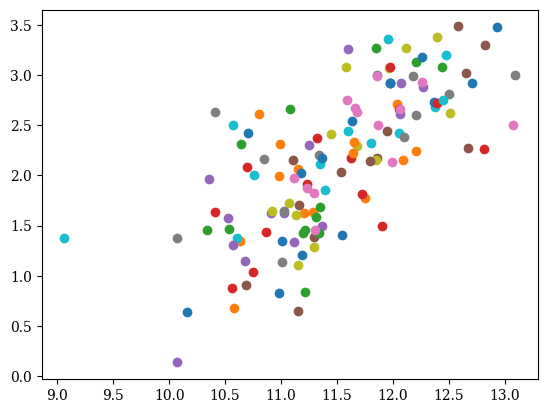

In [12]:
prior = 'lcdm_vmax_shm'
lmi_sparc,lsi_sparc,rni_sparc = [],[],[]
lmip_sparc,lsip_sparc,rnip_sparc = [],[],[]
lmim_sparc,lsim_sparc,rnim_sparc = [],[],[]
lbf_sparc = []
for gal in sparcd[prior]:
    bestfit = sparcd[prior][gal]['best_fit']
    gald = sparcd[prior][gal][bestfit]
    lm = gald['lm']
    lmstar = gald['lmstar']
    rdstar = gald['rdstar']
    rn = sparcd[prior][gal]['rlast']/gald['rs'][0]
    rnp = sparcd[prior][gal]['rlast']/(gald['rs'][0]-gald['rs'][1])
    rnm = sparcd[prior][gal]['rlast']/(gald['rs'][0]+gald['rs'][1])
    if rnp < rn:
        rnp = rn
    if rnm > rn:
        rnm = rn
    ls = np.log10(pp.sig_exp(lmstar[0],rdstar[0])) - 6
    lsp = np.log10(pp.sig_exp(lmstar[0]+lmstar[1],rdstar[0]-rdstar[1])) - 6
    lsm = np.log10(pp.sig_exp(lmstar[0]-lmstar[1],rdstar[0]+rdstar[1])) - 6
    lmi_sparc.append(LM_xi(lm[0]))
    lsi_sparc.append(LS_xi(ls))
    rni_sparc.append(RN_yi(rn))
    lmip_sparc.append(LM_xi(lm[0]+lm[1]))
    lsip_sparc.append(LS_xi(lsp))
    rnip_sparc.append(RN_yi(rnm))
    lmim_sparc.append(LM_xi(lm[0]-lm[1]))
    lsim_sparc.append(LS_xi(lsm))
    rnim_sparc.append(RN_yi(rnp))
    lbf_sparc.append(sparcd[prior][gal]['core_fit']['lnZ']-sparcd[prior][gal]['cusp_fit']['lnZ'])
    plt.scatter(lm[0],ls)
lmi_sparc,lsi_sparc,rni_sparc = np.array(lmi_sparc),np.array(lsi_sparc),np.array(rni_sparc)
lmip_sparc,lsip_sparc,rnip_sparc = np.array(lmip_sparc),np.array(lsip_sparc),np.array(rnip_sparc)
lmim_sparc,lsim_sparc,rnim_sparc = np.array(lmim_sparc),np.array(lsim_sparc),np.array(rnim_sparc)
lmi_err = np.array([lmi_sparc-lmim_sparc,lmip_sparc-lmi_sparc])
lsi_err = np.array([lsi_sparc-lsim_sparc,lsip_sparc-lsi_sparc])
rni_err = np.array([rni_sparc-rnim_sparc,rnip_sparc-rni_sparc])

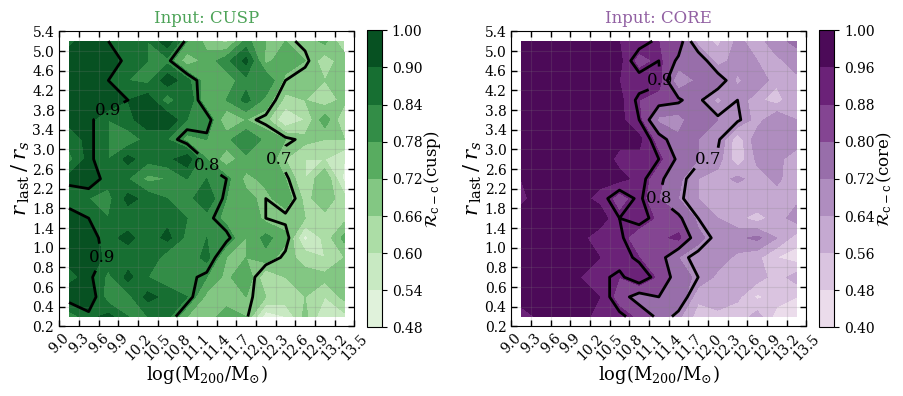

In [27]:
fig,ax1,ax2 = get_axes(0.4)

cn = ax1.contourf(LM,RN,Rlm_n, cmap = pa.gn_r)
cb = fig.colorbar(cn,ax = ax1, fraction = 0.046, pad = 0.04)
cb.set_label('$\mathcal{R}_\mathrm{c-c}\,(\mathrm{cusp})$',size = 12,labelpad = 0)
levels = [0.48,0.54,0.60,0.66,0.72,0.78,0.84,0.90,0.96]
cb.set_ticks(levels)
cb.set_ticklabels(['0.48','0.54','0.60','0.66','0.72','0.78','0.84','0.90','1.00'])
cn = ax1.contour(LM,RN,Rlm_n, levels = [0.7,0.8,0.9], colors = 'k', linewidths = 2)
cn = Delsmall(cn,4)
clabels = ax1.clabel(cn, inline = True, colors = 'k', fontsize = 12, rightside_up = True)
for cl in clabels:
    cl.set_rotation(0)
    
cn = ax2.contourf(LM,RN,Rlm_c, cmap = pa.pr)
cb = fig.colorbar(cn,ax = ax2, fraction = 0.046,pad = 0.04)
levels = [0.40,0.48,0.56,0.64,0.72,0.80,0.88,0.96,1.04]
cb.set_ticks(levels)
cb.set_ticklabels(['0.40','0.48','0.56','0.64','0.72','0.80','0.88','0.96','1.00'])
cb.set_label('$\mathcal{R}_\mathrm{c-c}\,(\mathrm{core})$',size = 12,labelpad = 0)
cn = ax2.contour(LM,RN,Rlm_c,levels = [0.7,0.8,0.9], colors = 'k',linewidths = 2)
Delsmall(cn,4)
clabels = ax2.clabel(cn, inline = True, colors = 'k', fontsize = 12, rightside_up = True)
for cl in clabels:
    cl.set_rotation(0)
    
plt.savefig('../Output/reliability/Bry_M200_rsize_1.pdf',bbox_inches = 'tight',dpi = 300)

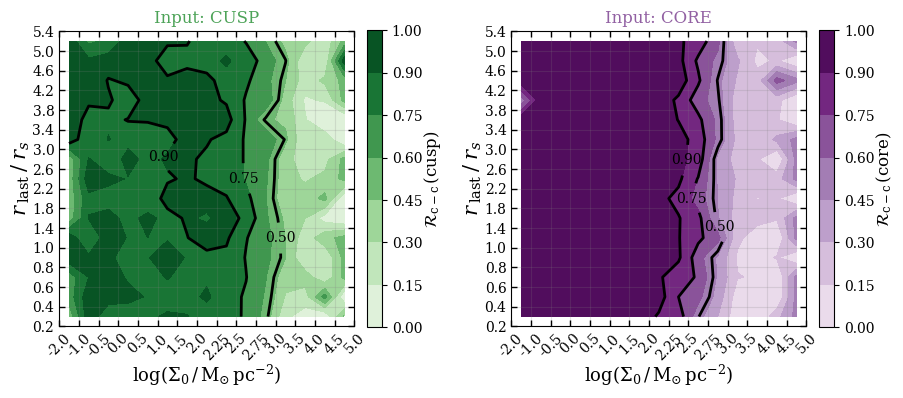

In [29]:
fig,ax1,ax2 = get_axes(0.4, xkey = ['ls','ls'])
cn = ax1.contourf(LM,RN,Rls_n,cmap = pa.gn_r)
cb = fig.colorbar(cn,ax = ax1, fraction = 0.046,pad = 0.04)
levels = [0,0.15,0.30,0.45,0.60,0.75,0.90,1.05]
cb.set_ticks(levels)
cb.set_ticklabels(['0.00','0.15','0.30','0.45','0.60','0.75','0.90','1.00'])
cb.set_label('$\mathcal{R}_\mathrm{c-c}\,(\mathrm{cusp})$',size = 12,labelpad = 0)
cn = ax1.contour(LM,RN,Rls_n,levels = [0.5,0.75,0.9], colors = 'k',linewidths = 2)
Delsmall(cn,10)
manual_locations = [(5,6),(8.6,7),(12,10)]
clabels = ax1.clabel(cn, inline = True, colors = 'k', fontsize = 10, 
                     rightside_up = True,manual = manual_locations)
for cl in clabels:
    cl.set_rotation(0)

cn = ax2.contourf(LM,RN,Rls_c,cmap = pa.pr)
cb = fig.colorbar(cn,ax = ax2, fraction = 0.046,pad = 0.04)
levels = [0,0.15,0.30,0.45,0.60,0.75,0.90,1.05]
cb.set_ticks(levels)
cb.set_ticklabels(['0.00','0.15','0.30','0.45','0.60','0.75','0.90','1.00'])
cb.set_label('$\mathcal{R}_\mathrm{c-c}\,(\mathrm{core})$',size = 12,labelpad = 0)
cn = ax2.contour(LM,RN,Rls_c,levels = [0.5,0.75,0.9], colors = 'k',linewidths = 2)
Delsmall(cn,4)
manual_locations = [(8,6),(8.6,8),(12,9)]
clabels = ax2.clabel(cn, inline = True, colors = 'k', fontsize = 10, 
                     rightside_up = True,manual = manual_locations)
for cl in clabels:
    cl.set_rotation(0)
    
plt.savefig('../Output/reliability/Bry_lsig_rsize_2.pdf',bbox_inches = 'tight',dpi = 300)

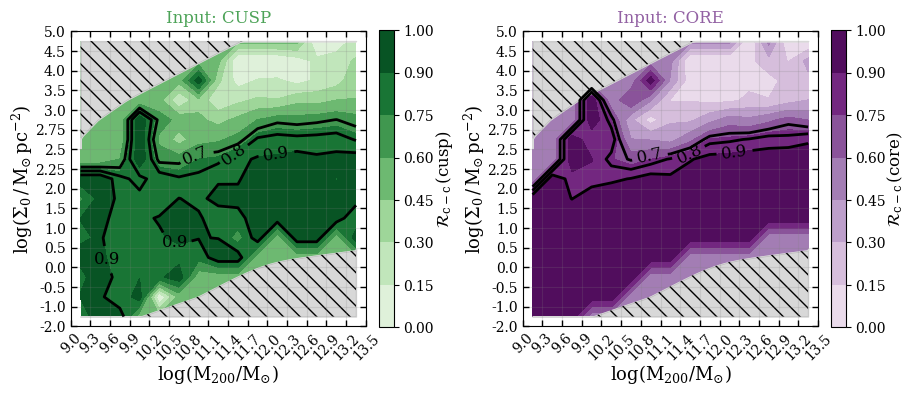

In [33]:
fig,ax1,ax2 = get_axes(0.4, ykey = ['ls','ls'])
cn = ax1.contourf(LM,RN,Rlmls_n,cmap = pa.gn_r)
cb = fig.colorbar(cn,ax = ax1, fraction = 0.046,pad = 0.04)
cb.set_label('$\mathcal{R}_\mathrm{c-c}\,(\mathrm{cusp})$',size = 12,labelpad = 0)
levels = [0,0.15,0.30,0.45,0.60,0.75,0.90,1.05]
cb.set_ticks(levels)
cb.set_ticklabels(['0.00','0.15','0.30','0.45','0.60','0.75','0.90','1.00'])
cn = ax1.contour(LM,RN,Rlmls_n,levels = [0.7,0.8,0.9], colors = 'k',linewidths = 2)
Delsmall(cn,13)
cn2 = ax1.contour(LM,RN,Rlmls_n,levels = [0.9], colors = 'k',linewidths = 2)
Delsmall(cn2,3)
clabels = ax1.clabel(cn, inline = True, colors = 'k', fontsize = 12, 
                     rightside_up = True,manual = [(8,6),(6,6)])
clabels = ax1.clabel(cn2, inline = True, colors = 'k', fontsize = 12, 
                     rightside_up = True,manual = [(10,6),(5,10),[2,11]])
for cl,i in zip(clabels,range(3)):
    if i == 0:
        pass
    else:
        cl.set_rotation(0)



cn = ax2.contourf(LM,RN,Rlmls_c,cmap = pa.pr)
cb = fig.colorbar(cn,ax = ax2, fraction = 0.046,pad = 0.04)
cb.set_label('$\mathcal{R}_\mathrm{c-c}\,(\mathrm{core})$',size = 12,labelpad = 0)
levels = [0,0.15,0.30,0.45,0.60,0.75,0.90,1.05]
cb.set_ticks(levels)
cb.set_ticklabels(['0.00','0.15','0.30','0.45','0.60','0.75','0.90','1.00'])
cn = ax2.contour(LM,RN,Rlmls_c,levels = [0.7,0.8,0.9], colors = 'k',linewidths = 2)
Delsmall(cn,12)
manual_locations = [(6,6),(8,5.8),(11,9)]
clabels = ax2.clabel(cn, inline = True, colors = 'k', fontsize = 12, 
                     rightside_up = True,manual = manual_locations)

for ax in [ax1,ax2]:
    ax.fill_between(LM_xi(Lm),LS_yi(lsig_low),np.ones(len(Lm))*14, color = 'white',alpha = 1)
    ax.fill_between(LM_xi(Lm),LS_yi(lsig_hig),np.ones(len(Lm))*0, color = 'white',alpha = 1)
    ax.fill_between(LM_xi(Lm),LS_yi(lsig_low),np.ones(len(Lm))*14, color = 'grey',alpha = 0.3)
    ax.fill_between(LM_xi(Lm),LS_yi(lsig_hig),np.ones(len(Lm))*0, color = 'grey',alpha = 0.3)
    ax.fill_between(LM_xi(Lm),LS_yi(lsig_low),np.ones(len(Lm))*14,alpha = 0,hatch = '\\\\')
    ax.fill_between(LM_xi(Lm),LS_yi(lsig_hig),np.ones(len(Lm))*0,alpha = 0,hatch = '\\\\')
    # ax.scatter(lmi_sparc,14-lsi_sparc)
    
plt.savefig('../Output/reliability/Bry_M200_lsig_1.pdf',bbox_inches = 'tight',dpi = 300)

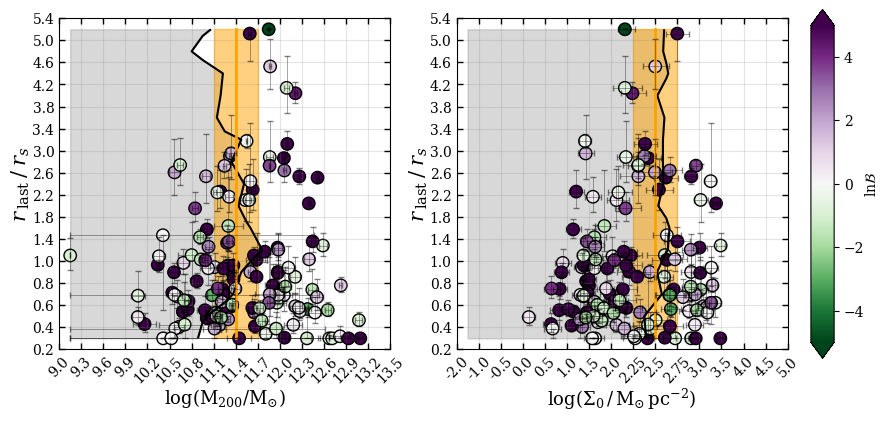

In [264]:
fig,ax1,ax2 = get_axes(0.2,xkey = ['lm','ls'])

orange = (1,.64,0)

Rlm,Rls = np.zeros([15,15]),np.zeros([15,15])
for i in range(15):
    for j in range(15):
        Rlm[i,j] = np.min([Rlm_n[i,j],Rlm_c[i,j]])
        Rls[i,j] = np.min([Rls_n[i,j],Rls_c[i,j]])

cn = ax1.contour(LM,RN,Rlm,levels = [0.75],colors = 'k')
cn = Delsmall(cn,4)
level = cn.collections[0]
v = level.get_paths()[0].vertices
x,y = v[:,0],v[:,1]
ax1.fill_betweenx(y,x,np.zeros(len(x)),color = 'grey',alpha = 0.3)
ax1.plot([7.5,7.5],[14,0], c = orange,ls = '-',lw = 2)
ax1.fill_betweenx([14,0],[6.5,6.5],[8.5,8.5], color = orange, alpha = 0.5)
ax1.errorbar(lmi_sparc,rni_sparc,xerr = lmi_err, yerr = rni_err, fmt = '.', ecolor = 'k',
             capsize = 2,elinewidth = 0.5, alpha = 0.5,color = 'none')
ax1.scatter(lmi_sparc,rni_sparc,cmap = pa.prgn_r, c = lbf_sparc, marker = 'o',
            s = 80,vmin = -5, vmax = 5, edgecolor = 'k')



cn = ax2.contour(LM,RN,Rls,levels = [0.75],colors = 'k')
Delsmall(cn,6)
level = cn.collections[0]
v = level.get_paths()[0].vertices
x,y = v[:,0],v[:,1]
ax2.fill_betweenx(y,x,np.zeros(len(x)),color = 'grey',alpha = 0.3)
ax2.plot([8.5,8.5],[14,0], c = orange,ls = '-',lw = 2)
ax2.fill_betweenx([14,0],[7.5,7.5],[9.5,9.5], color = orange, alpha = 0.5)
ax2.errorbar(lsi_sparc,rni_sparc,xerr = lsi_err, yerr = rni_err, fmt = '.', ecolor = 'k',
             capsize = 2,elinewidth = 0.5, alpha = 0.5,color = 'none')
sc = ax2.scatter(lsi_sparc,rni_sparc,cmap = pa.prgn_r, c = lbf_sparc, marker = 'o',
            s = 80,vmin = -5, vmax = 5, edgecolor = 'k')


cb = fig.colorbar(sc, ax = np.array([ax1,ax2]).ravel().tolist(), extend = 'both', aspect = 15,
                  fraction = 0.03, pad = 0.03)
cb.set_label('$\mathrm{ln}\mathcal{B}$',labelpad = 0)

for ax in [ax1,ax2]:
    ax.set_title('')
    
# plt.savefig('../Output/reliability/Bry_M200_and_lsig_rsize_SPARC_1.pdf',bbox_inches = 'tight',dpi = 300)

In [267]:
reliability = {'Relcc_lm':Rlm.tolist(), 'Relcc_ls':Rls.tolist()}

In [268]:
json.dump(reliability, open('../Output/reliabilities.json','w'),indent = 2)